<a href="https://colab.research.google.com/github/wisnalaa/Pred_Stroke/blob/main/Skripsi_(Riyal_cuy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Model
import lightgbm as lgb

# Explainability
import shap

#LOAD DATASET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Skripsi/healthcare-dataset-stroke-data.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#EDA

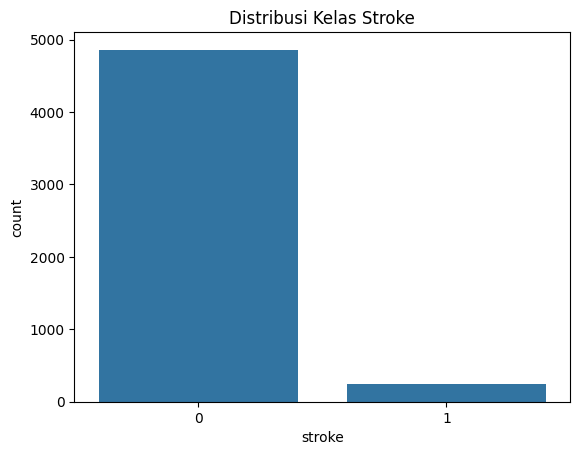

In [4]:
sns.countplot(x='stroke', data=df)
plt.title('Distribusi Kelas Stroke')
plt.show()

In [5]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [6]:
# Menghapus kolom ID (tidak relevan untuk prediksi)
df = df.drop('id', axis=1)

In [7]:
# Membersihkan data Gender 'Other' (hanya 1 data, dianggap noise)
df = df[df['gender'] != 'Other']

In [8]:
# Menangani Missing Values pada BMI
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median)

In [9]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


#ENCODING

In [10]:
# Mengubah data kategori (teks) menjadi angka
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print(df.head())
df.info()

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               1             228.69  36.6               1       1  
1               0             202.21  28.1               2       1  
2               0             105.92  32.5               2       1  
3               1             171.23  34.4               3       1  
4               0             174.12  24.0               2       1  
<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype

#SPLIT DATA

In [11]:
X = df.drop('stroke', axis=1)
y = df['stroke']

# Stratify=y penting agar proporsi stroke di data latih dan uji seimbang
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nJumlah Data Training: {X_train.shape[0]}")
print(f"Jumlah Data Testing: {X_test.shape[0]}")


Jumlah Data Training: 4087
Jumlah Data Testing: 1022


#MODELLING

In [12]:
# Menghitung Scale Pos Weight untuk menangani Imbalanced Data
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"\nCalculated Scale Pos Weight: {ratio:.2f}")


Calculated Scale Pos Weight: 19.54


In [13]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [14]:
# Parameter Optimal
params = {
    'objective': 'binary',             # Klasifikasi biner
    'metric': 'auc',                   # Metrik optimasi
    'scale_pos_weight': ratio,         # Menangani imbalance
    'boosting_type': 'gbdt',
    'num_leaves': 20,                  # Kompleksitas tree
    'max_depth': 5,                    # Batas kedalaman tree
    'learning_rate': 0.03,             # Learning rate
    'feature_fraction': 0.8,           # Random feature sampling
    'verbose': -1,
    'seed': 42
}

In [15]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), # Stop jika tidak ada perbaikan dalam 50 putaran
        lgb.log_evaluation(0) # Silent mode
    ]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	training's auc: 0.946613	valid_1's auc: 0.834722


#EVALUASI MODEL

In [16]:
y_pred_prob = model.predict(X_test)

In [17]:
FINAL_THRESHOLD = 0.4
y_pred_final = (y_pred_prob > FINAL_THRESHOLD).astype(int)

print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.82      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022



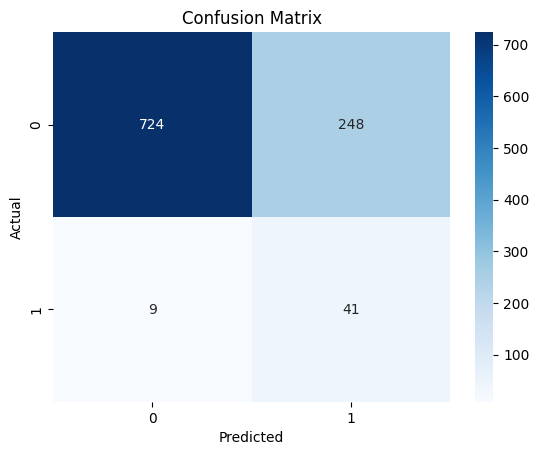

In [18]:
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.8347


#SHAP

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [21]:
if isinstance(shap_values, list):
    shap_vals_target = shap_values[1]
else:
    shap_vals_target = shap_values

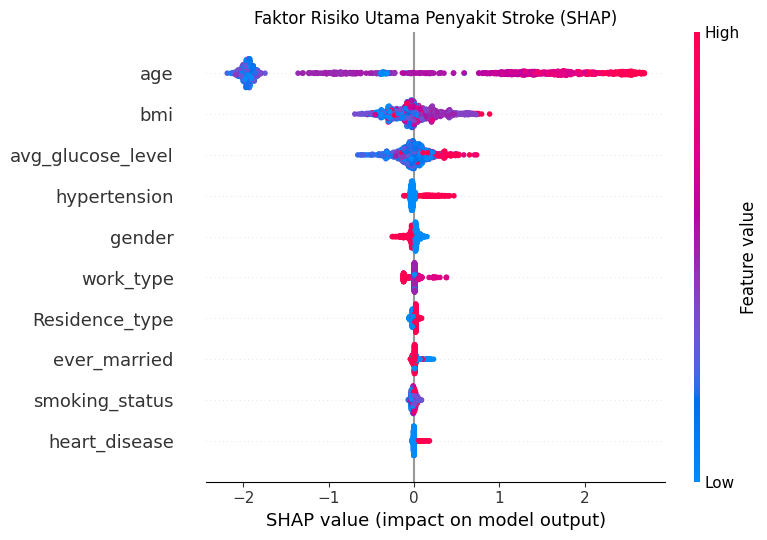

In [22]:
# Plot
plt.figure(figsize=(10, 6))
plt.title("Faktor Risiko Utama Penyakit Stroke (SHAP)")
shap.summary_plot(shap_vals_target, X_test, show=False)
plt.show()

#Testing

In [26]:
# 1. Masukkan Data Pasien di sini (Silakan ganti-ganti angkanya)
input_data = {
    'gender': 'Male',              # Male / Female
    'age': 25,                     # Umur
    'hypertension': 0,             # 0: Tidak, 1: Ya
    'heart_disease': 0,            # 0: Tidak, 1: Ya
    'ever_married': 'Yes',         # Yes / No
    'work_type': 'Private',        # Private, Self-employed, Govt_job, children
    'Residence_type': 'Urban',     # Urban / Rural
    'avg_glucose_level': 85,   # Kadar Gula Darah
    'bmi': 36.6,                   # Berat Badan (BMI)
    'smoking_status': 'formerly smoked' # formerly smoked, never smoked, smokes, Unknown
}

# 2. Buat DataFrame dari input
new_df = pd.DataFrame([input_data])
print("Data Pasien Baru:")
display(new_df)

# 3. Preprocessing (Encoding) - SAMA PERSIS DENGAN TRAINING
# Kita gunakan label_encoders yang sudah dibuat saat training tadi
try:
    for col in cat_cols:
        if col in new_df.columns:
            # Menggunakan encoder yang sudah dilatih sebelumnya
            # Hati-hati: Jika ada kategori baru yang tidak ada di training, ini bisa error
            # Solusi praktis: Pastikan input sesuai opsi yang ada
            new_df[col] = label_encoders[col].transform(new_df[col])
except Exception as e:
    print(f"Error Encoding: {e}")
    print("Pastikan input teks sesuai dengan data training!")

# 4. Prediksi
# Mendapatkan probabilitas (0.0 - 1.0)
probabilitas = model.predict(new_df)[0]
persentase = probabilitas * 100

# Menggunakan Threshold Optimal 0.4
status = "BERISIKO STROKE" if probabilitas > 0.4 else "TIDAK BERISIKO"

# 5. Tampilkan Hasil
print(f"\n=== HASIL PREDIKSI ===")
print(f"Probabilitas Stroke : {persentase:.2f}%")
print(f"Status              : {status}")

# 6. Penjelasan SHAP (Kenapa hasilnya begitu?)
print("\n--- Alasan Prediksi (SHAP Force Plot) ---")
# Hitung SHAP value untuk data baru ini
explainer = shap.TreeExplainer(model)
shap_values_single = explainer.shap_values(new_df)

# Handling format SHAP output
if isinstance(shap_values_single, list):
    shap_val = shap_values_single[1][0]
    base_val = explainer.expected_value[1]
else:
    shap_val = shap_values_single[0]
    base_val = explainer.expected_value

# Visualisasi Force Plot
shap.initjs() # Wajib untuk visualisasi interaktif di Colab
shap.force_plot(base_val, shap_val, new_df)

Data Pasien Baru:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,25,0,0,Yes,Private,Urban,85,36.6,formerly smoked



=== HASIL PREDIKSI ===
Probabilitas Stroke : 1.51%
Status              : TIDAK BERISIKO

--- Alasan Prediksi (SHAP Force Plot) ---


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
